# 🦠 Emergent Molecular Communication

A preliminary study of emergent molecular communication protocols learned by graph-based agents in a diffusion channel environment.

## Table of Contents
- [Imports](#introduction)
- [Utils](#utils)
  - [Data](#data)
  - [Neural Networks](#neural-networks)
  - [Communication Model](#communication-model)
  - [Train the Communication Model](#train-the-communication-model)
- [Running the Experiments](#running-the-experiments)
  - [Experiments on Ideal and Diffusion Channel](#experiments-on-ideal-and-diffusion-channel)
  - [Experiments on Pure Relay Nodes](#experiments-on-pure-relay-nodes)
- [Collect and Visualize Results](#collect-and-visualize-results)
- [RL Environment](#rl-environment)
- [RL Agent](#rl-agent)

## Imports

In [1]:
import os
import gymnasium as gym # new import 
from gymnasium import spaces # new import 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F  
from typing import Optional, Tuple, Union, Dict, List, Any # Used older version of python (3.8), needed to import some type annotations

import warnings
from copy import deepcopy
import logging
from logging import getLogger
import math
import random
from random import shuffle
from itertools import product
from datetime import datetime
import glob
from functools import cache
from tqdm import tqdm

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy.special import erfc
from ucimlrepo import fetch_ucirepo


import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import ray
from stable_baselines3 import PPO # new import 
from stable_baselines3.common.env_util import make_vec_env # new import 
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback # new import 


sns.set_style("whitegrid")


logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = getLogger(__name__)


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## Utils

### Data

In [2]:
def generate_graph(
    n_nodes: int, density: float, random_state: Optional[int] = None
) -> np.ndarray:
    """
    Generate random (x, y) positions for nodes in a graph.

    The nodes are uniformly distributed in a square region.
    The side length of the square is computed based on the given density,
    so that the area of the square is n_nodes/density.

    Parameters:
        n_nodes (int): Number of nodes.
        density (float): Average number of nodes per unit square.
        random_state (int): Seed for the random number generator.

    Returns:
        np.ndarray: An array of shape (n_nodes, 2) with the (x, y) positions.
    """
    # Initialize the random number generator with the provided seed.
    if random_state is not None:
        rng = np.random.default_rng(random_state)

    # Compute the side length of the square domain.
    side_length = np.sqrt(n_nodes / density)

    # Generate positions uniformly in the square [0, side_length] x [0, side_length].
    positions = rng.uniform(low=0, high=side_length, size=(n_nodes, 2))

    return positions


def get_sender_receiver(graph: np.ndarray) -> tuple[int, int]:
    """
    Return the index of the sender and receiver nodes. The sender and the receiver are the nodes
    that are furthest apart in the graph.

    Parameters:
        graph (np.ndarray): An array of shape (n_nodes, 2) with the (x, y) positions of the nodes.

    Returns:
        Tuple[int, int]: The indices of the sender and receiver nodes.
    """
    # Compute the pairwise distances between all nodes.
    distances = np.linalg.norm(graph[:, None] - graph, axis=-1)

    # Find the indices of the sender and receiver nodes.
    sender, receiver = np.unravel_index(np.argmax(distances), distances.shape)

    return sender.item(), receiver.item()


def get_distance_matrix(graph: np.ndarray) -> np.ndarray:
    """
    Compute the pairwise distance matrix between all nodes in the graph.

    Parameters:
        graph (np.ndarray): An array of shape (n_nodes, 2) with the (x, y) positions of the nodes.

    Returns:
        np.ndarray: A distance matrix of shape (n_nodes, n_nodes) where the entry (i, j) is the
            Euclidean distance between nodes i and j.
    """
    # Compute the pairwise distances between all nodes.
    distances = np.linalg.norm(graph[:, None] - graph, axis=-1)

    return distances


def plot_graph(graph: np.ndarray, ax=None):
    """
    Plot the graph with nodes and edges.

    Parameters:
        graph (np.ndarray): An array of shape (n_nodes, 2) with the (x, y) positions of the nodes.
        ax (plt.Axes): The axes where to plot the graph.
    """
    if ax is None:
        _, ax = plt.subplots()

    # Plot the nodes.
    ax.plot(graph[:, 0], graph[:, 1], "o", label="Nodes")
    for i, (x, y) in enumerate(graph):
        ax.text(x, y, f"{i}", ha="center", va="bottom")

    # Plot the sender and the receiver nodes with a different color.
    sender, receiver = get_sender_receiver(graph)
    ax.plot(graph[sender, 0], graph[sender, 1], "o", color="green", label="Sender")
    ax.plot(graph[receiver, 0], graph[receiver, 1], "o", color="red", label="Receiver")

    ax.set_aspect("equal", "box")
    ax.grid(True)
    ax.legend()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("Graph")

In [3]:
DATASETS = [
    "iris",
    "wine",
    "breast_cancer",
]

def get_classification_data(
    dataset_name: str,
    test_size: float = 0.2,
    val_size: float = 0.1,
    random_state: int = 42,
):
    """
    Load a dataset from OpenML (UCI repository) and preprocess it:
    - Detect numerical and categorical features
    - Impute missing values
    - One-hot encode categorical features
    - Standardize all features
    - Encode target labels
    - Split into train/validation/test sets

    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test as numpy arrays
    """
    # Check if the dataset is in the list of available datasets
    if dataset_name not in DATASETS:
        raise ValueError(
            f"Dataset {dataset_name} is not available. Please choose from {DATASETS}."
        )

    # Check if the dataset file exists
    dataset_path = os.path.join("..", "data", f"{dataset_name}.npz")
    if os.path.exists(dataset_path):
        with np.load(dataset_path, allow_pickle=False) as data:
            X_train = data["X_train"]
            X_val = data["X_val"]
            X_test = data["X_test"]
            y_train = data["y_train"]
            y_val = data["y_val"]
            y_test = data["y_test"]
        return X_train, X_val, X_test, y_train, y_val, y_test

    # fetch dataset
    ids = {
        "iris": 53,
        "wine": 109,
        "breast_cancer": 17,
    }
    if dataset_name not in DATASETS:
        raise ValueError(
            f"Dataset {dataset_name} is not available. Please choose from {DATASETS}."
        )

    ds = fetch_ucirepo(id=ids[dataset_name])
    X = ds.data.features
    y = ds.data.targets

    # Identify feature types
    numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
    categorical_features = [col for col in X.columns if col not in numeric_features]

    # Pipelines for numerical and categorical features
    numeric_pipeline = Pipeline(
        [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
    )
    categorical_pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocessor = ColumnTransformer(
        [
            ("num", numeric_pipeline, numeric_features),
            ("cat", categorical_pipeline, categorical_features),
        ]
    )

    # Encode target labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )
    # Adjust validation size relative to the remaining data
    val_relative_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp,
        y_temp,
        test_size=val_relative_size,
        random_state=random_state,
        stratify=y_temp,
    )

    # Fit the preprocessor on the training data and transform all sets
    if dataset_name in ids:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X_train_processed = preprocessor.fit_transform(X_train)
            X_val_processed = preprocessor.transform(X_val)
            X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed = X_train
        X_val_processed = X_val
        X_test_processed = X_test

    # Save the dataset as a numpy array
    os.makedirs(os.path.join("..", "data"), exist_ok=True)
    np.savez_compressed(
        os.path.join("..", "data", f"{dataset_name}.npz"),
        X_train=X_train_processed,
        X_val=X_val_processed,
        X_test=X_test_processed,
        y_train=y_train,
        y_val=y_val,
        y_test=y_test,
        allow_pickle=False,
    )

    return X_train_processed, X_val_processed, X_test_processed, y_train, y_val, y_test


data_stats_dict = {
    "name": [],
    "n_samples": [],
    "n_features": [],
    "n_classes": [],
}
for dataset in DATASETS:
    X_train, X_val, X_test, y_train, y_val, y_test = get_classification_data(dataset)
    data_stats_dict["name"].append(dataset)
    data_stats_dict["n_samples"].append(
        X_train.shape[0] + X_val.shape[0] + X_test.shape[0]
    )
    data_stats_dict["n_features"].append(X_train.shape[1])
    data_stats_dict["n_classes"].append(len(np.unique(y_train)))
data_stats_df = pd.DataFrame(data_stats_dict)
data_stats_df

,name,n_samples,n_features,n_classes
0,iris,150,4,3
1,wine,178,13,3
2,breast_cancer,569,30,2


### Neural Networks

In [4]:
class FeedForwardNeuralNetwork(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_dims: list = [4],
        dropout_rate: float = 0.0,
        use_batchnorm: bool = False,
    ):
        """
        Feedforward Neural Network with ReLU activations and Dropout.

        Parameters:
            in_features (int): Dimensionality of the input features.
            out_features (int): Dimensionality of the output features.
            hidden_dims (list): List with the number of neurons for each hidden layer.
            dropout_rate (float): Dropout probability.
            use_batchnorm (bool): Whether to use Batch Normalization.
            residual_coefficient (float): Coefficient for the residual connection.
            output_coefficient (float): Coefficient for the output layer.
        """
        super().__init__()
        layers = []
        prev_dim = in_features
        # Build hidden layers
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = h
        layers.append(nn.Linear(prev_dim, out_features))
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Parameters:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        return self.network(x)

In [5]:
def train_encoder_decoder(
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    n_features,
    n_classes,
    hidden_dims,
    use_batchnorm,
    lr=1e-3,
    n_epochs=50,
    patience=5,
    lr_drop_after=0.5,
    warmup_epochs=10,
    l1_lambda=0.01,
    batch_size=256,
    device="cpu",
    weights_dir="enc_dec_weights",
    verbose=False,
):
    os.makedirs(weights_dir, exist_ok=True)
    torch.manual_seed(42)
    np.random.seed(42)

    # Build the two networks
    n_chem = n_classes
    encoder = FeedForwardNeuralNetwork(
        in_features=n_features,
        out_features=n_chem,
        hidden_dims=hidden_dims,
        use_batchnorm=use_batchnorm,
    ).to(device)
    decoder = FeedForwardNeuralNetwork(
        in_features=n_chem,
        out_features=n_classes,
        hidden_dims=hidden_dims,
        use_batchnorm=use_batchnorm,
    ).to(device)

    # Joint optimizer & loss
    optimizer = optim.Adam(
        list(encoder.parameters()) + list(decoder.parameters()), lr=lr
    )
    criterion = nn.CrossEntropyLoss()

    # DataLoaders
    train_ds = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long), # <--- Add dtype=torch.long
)
    val_ds = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.long),   # <--- Add dtype=torch.long
)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    best_acc = 0.0
    best_enc = deepcopy(encoder.state_dict())
    best_dec = deepcopy(decoder.state_dict())
    no_imp = 0

    for epoch in range(1, n_epochs + 1):
        # — train epoch —
        encoder.train()
        decoder.train()
        running = total = 0.0
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            chem = encoder(Xb)
            logits = decoder(chem)
            loss = criterion(logits, yb)

            # Add L1 regularization
            l1_norm = sum(p.abs().sum() for p in encoder.parameters()) + sum(
                p.abs().sum() for p in decoder.parameters()
            )
            loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            running += loss.item() * Xb.size(0)
            total += Xb.size(0)

        # — validation epoch —
        encoder.eval()
        decoder.eval()
        vrun = vtot = 0.0
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                vchem = encoder(Xb)
                vlogits = decoder(vchem)
                vrun += criterion(vlogits, yb).item() * Xb.size(0)
                vtot += Xb.size(0)

        train_loss = running / total
        val_loss = vrun / vtot
        val_acc = (vlogits.argmax(dim=1) == yb).float().mean().item()
        if verbose:
            logger.info(
                f"[EncDec] Epoch {epoch}: train={train_loss:.4f} val={val_loss:.4f} acc={val_acc:.4f}"
            )

        # early stop
        if val_acc > best_acc:
            best_acc = val_acc
            best_enc = deepcopy(encoder.state_dict())
            best_dec = deepcopy(decoder.state_dict())
            no_imp = 0
        else:
            no_imp += 1
            if no_imp >= patience and epoch > warmup_epochs:
                if verbose:
                    logger.warning("Encoder-decoder pretraining stopped early.")
                break

        # learning rate drop
        drop_epoch = math.ceil(n_epochs * lr_drop_after)
        if epoch > warmup_epochs and epoch == drop_epoch:
            for g in optimizer.param_groups:
                g["lr"] = lr / 10
            if verbose:
                logger.info(f"Learning rate dropped to {lr / 10:.1e} at epoch {epoch}.")

    # save best
    encoder.load_state_dict(best_enc)
    decoder.load_state_dict(best_dec)
    enc_path = os.path.join(weights_dir, f"{dataset_name}_encoder_weights.pth")
    dec_path = os.path.join(weights_dir, f"{dataset_name}_decoder_weights.pth")
    torch.save(encoder.state_dict(), enc_path)
    torch.save(decoder.state_dict(), dec_path)
    if verbose:
        logger.debug(f"Saved encoder → {enc_path}")
        logger.debug(f"Saved decoder → {dec_path}")

    # test
    encoder.eval()
    decoder.eval()
    correct, total = 0.0, 0.0
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            tchem = encoder(Xb)
            tlogits = decoder(tchem)
            correct += (tlogits.argmax(dim=1) == yb).float().sum().item()
            total += Xb.size(0)
    test_acc = correct / total
    return enc_path, dec_path, test_acc


os.makedirs("enc_dec_weights", exist_ok=True)
res_csv_path = os.path.join("enc_dec_weights", "enc_dec_results.csv")
if os.path.exists(res_csv_path):
    df = pd.read_csv(res_csv_path)
else:
    df = pd.DataFrame(columns=["dataset", "n_features", "n_classes", "acc"])
    df.to_csv(res_csv_path, index=False)

for dataset_name in DATASETS:
    if dataset_name in ["identity", "shift", "negate"]:
        continue
    enc_path = os.path.join("enc_dec_weights", f"{dataset_name}_encoder_weights.pth")
    dec_path = os.path.join("enc_dec_weights", f"{dataset_name}_decoder_weights.pth")
    if not os.path.exists(enc_path) or not os.path.exists(dec_path):
        X_train, X_val, X_test, y_train, y_val, y_test = get_classification_data(
            dataset_name
        )
        n_features = X_train.shape[1]
        n_classes = len(np.unique(y_train))
        _, _, acc = train_encoder_decoder(
            X_train,
            y_train,
            X_val,
            y_val,
            X_test,
            y_test,
            n_features,
            n_classes,
            hidden_dims=[],
            use_batchnorm=False,
            lr=1e-3,
            n_epochs=10000,
            patience=100,
            batch_size=1024,
            device="cpu",
            weights_dir="enc_dec_weights",
        )
        logger.info(f"Trained encoder-decoder on {dataset_name}. Acc: {acc:.4f}")
        df = pd.read_csv(res_csv_path)
        new_row = pd.DataFrame(
            {
                "dataset": [dataset_name],
                "n_features": [n_features],
                "n_classes": [n_classes],
                "acc": [acc],
            }
        )
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv(res_csv_path, index=False)
    else:
        logger.info(f"Encoder-decoder weights already exist for {dataset_name}.")

2025-06-27 10:34:27,234 - INFO - Encoder-decoder weights already exist for iris.
2025-06-27 10:34:27,235 - INFO - Encoder-decoder weights already exist for wine.
2025-06-27 10:34:27,236 - INFO - Encoder-decoder weights already exist for breast_cancer.


### Communication Model

In [6]:
def message_passing(
    message: torch.Tensor,
    distance: torch.Tensor,
    phi: nn.ModuleList,
    residual_coefficient: float = 0.0,
    output_coefficient: float = 1.0,
    use_diffusion_noise: bool = True,
    memory: bool = False,
) -> torch.Tensor:
    """
    Perform one message passing iteration, optionally incorporating memory.

    Parameters:
        message: Tensor of shape (B, n, d)  -- messages at current iteration
        distance: Tensor of shape (n, n)     -- distance matrix between nodes
        phi:     ModuleList of n mappings   -- each maps R^{d or 2d} -> R^d
        residual_coefficient: float         -- coefficient for residual connection
        output_coefficient: float          -- coefficient for output layer
        use_diffusion_noise: bool          -- whether to add diffusion noise
        memory:  bool                        -- whether to concatenate previous message

    Returns:
        new_message: Tensor of shape (B, n, d) -- updated messages
    """
    B, N, D = message.shape

    # Save previous messages if memory is on
    prev_msg = message.clone() if memory else None

    # Compute detection probabilities
    p = torch.erfc(distance / 2.0)  # (n, n)
    p_exp = p.unsqueeze(0).unsqueeze(-1).expand(B, N, N, D)  # (B,n,n,d)

    # Channel noise
    if use_diffusion_noise:
        eps = torch.randn(B, N, N, D, device=message.device)
        Delta = (p_exp * (1 + eps - eps * p_exp)).clip(min=0)  # (B,n,n,d)
    else:
        Delta = torch.ones_like(p_exp, device=message.device)

    # Compute aggregated messages
    aggregated = torch.einsum("bijk,bjk->bik", Delta, message)  # (B,n,d)

    # Compute new messages per node
    new_message = torch.zeros_like(message, device=message.device)
    for i in range(N):
        if memory:
            # concat along feature dim: [aggregated, previous]
            inp = torch.cat([aggregated[:, i, :], prev_msg[:, i, :]], dim=-1)
        else:
            inp = aggregated[:, i, :]
        new_message[:, i, :] = phi[i](inp)

    # Apply residual connection
    new_message = residual_coefficient * message + output_coefficient * new_message
    return new_message


class MolComNetwork(nn.Module):
    def __init__(
        self,
        graph: np.ndarray,
        n_features: int,
        n_classes: int,
        encoder: torch.nn.Module = None,
        n_iters: int = 1,
        hidden_dims: list = [4],
        dropout_rate: float = 0.0,
        use_batchnorm: bool = False,
        residual_coefficient: float = 0.0,
        output_coefficient: float = 1.0,
        use_diffusion_noise: bool = True,
        memory: bool = False,
        freeze_encoders: bool = False,
    ):
        super().__init__()
        self.n_features = n_features
        self.graph = graph
        self.graph_size = len(graph)
        self.distances = torch.tensor(get_distance_matrix(graph), dtype=torch.float32)
        self.sender, self.receiver = get_sender_receiver(graph)
        self.n_iters = n_iters
        self.residual_coefficient = residual_coefficient
        self.output_coefficient = output_coefficient
        self.n_classes = n_classes
        self.use_diffusion_noise = use_diffusion_noise
        self.memory = memory

        # Encoder unchanged
        self.encoder = encoder
        if freeze_encoders and encoder is not None:
            for param in self.encoder.parameters():
                param.requires_grad = False

        # φ‐networks: double in_features if memory=True
        phi_in = 2 * n_classes if memory else n_classes
        self.phi = nn.ModuleList(
            [
                FeedForwardNeuralNetwork(
                    in_features=phi_in,
                    out_features=n_classes,
                    hidden_dims=hidden_dims,
                    dropout_rate=dropout_rate,
                    use_batchnorm=use_batchnorm,
                )
                for _ in range(self.graph_size)
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B = x.size(0)
        self.distances = self.distances.to(x.device)
        assert (
            x.shape[1] == self.n_features
        ), f"Expected {self.n_features} features, got {x.shape[1]}"

        # Initialize messages: only sender nodes get the encoded signal
        msg = torch.zeros(B, self.graph_size, self.n_classes, device=x.device)
        msg[:, self.sender, :] = self.encoder(x) if self.encoder is not None else x
        msg = torch.relu(msg)
        out = torch.zeros(B, self.n_classes, self.n_iters, device=x.device)

        # Iterative message passing
        for i in range(self.n_iters):
            msg = message_passing(
                msg,
                self.distances,
                self.phi,
                residual_coefficient=self.residual_coefficient,
                output_coefficient=self.output_coefficient,
                memory=self.memory,
                use_diffusion_noise=self.use_diffusion_noise,
            )
            msg = torch.relu(msg)
            # Save the output of the last iteration
            out[:, :, i] = msg[:, self.receiver, :]

        return out

### Train the Communication Model

In [7]:
def compute_iter_metrics(
    outputs: torch.Tensor, targets: torch.Tensor, k: int
) -> dict[str, float | list[float]]:
    """
    Returns a dict with:
      - acc_last       float
      - acc_avg        float
      - mean_first     float
      - conv_rate      float
      - stability      float
      - acc_per_iter   list[float]
    """
    B, C, T = outputs.shape

    preds = outputs.argmax(dim=1)  # (B, T)
    correct = preds.eq(targets.unsqueeze(1))  # (B, T)
    acc_per_iter = correct.float().mean(dim=0).tolist()

    acc_last = acc_per_iter[-1]

    probs = F.softmax(outputs, dim=1)  # (B, C, T)
    acc_avg = (probs.mean(dim=2).argmax(dim=1) == targets).float().mean().item()

    idx = torch.arange(T, device=outputs.device).unsqueeze(0).expand(B, T)
    first_idx = torch.where(correct, idx, torch.full_like(idx, T)).min(dim=1)[0] + 1
    valid = first_idx <= T
    mean_first = first_idx[valid].float().mean().item() if valid.any() else float("nan")

    k_clamped = max(1, min(k, T))
    stable = (preds[:, k_clamped - 1].unsqueeze(1) == preds[:, k_clamped - 1 :]).all(
        dim=1
    )
    conv_rate = stable.float().mean().item()

    flips = (preds[:, 1:] != preds[:, :-1]).float().sum(dim=1)
    stability = 1 - (flips / (T - 1)).mean().item()

    return {
        "acc_last": acc_last,
        "acc_avg": acc_avg,
        "mean_first": mean_first,
        "conv_rate": conv_rate,
        "stability": stability,
        "acc_per_iter": acc_per_iter,
    }


def train_one_epoch(model, loader, optimizer, criterion, device, k):
    model.train()
    meters = {
        "loss": 0.0,
        "acc_last": 0.0,
        "acc_avg": 0.0,
        "mean_first": 0.0,
        "conv_rate": 0.0,
        "stability": 0.0,
        "acc_per_iter": None,  # will become list
        "count": 0,
    }

    for X, y in loader:
        B = X.size(0)
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        out = model(X)  # (B, C, T)
        T = out.size(2)

        loss = sum(criterion(out[:, :, t], y) for t in range(T)) / T
        loss.backward()
        optimizer.step()

        metrics = compute_iter_metrics(out, y, k)

        meters["loss"] += loss.item() * B
        meters["acc_last"] += metrics["acc_last"] * B
        meters["acc_avg"] += metrics["acc_avg"] * B
        meters["mean_first"] += metrics["mean_first"] * B
        meters["conv_rate"] += metrics["conv_rate"] * B
        meters["stability"] += metrics["stability"] * B

        if meters["acc_per_iter"] is None:
            meters["acc_per_iter"] = torch.zeros(T, dtype=torch.float64)
        meters["acc_per_iter"] += (
            torch.tensor(metrics["acc_per_iter"], dtype=torch.float64) * B
        )

        meters["count"] += B

    # normalize
    N = meters["count"]
    epoch = {
        k: (v / N if k != "acc_per_iter" else (meters["acc_per_iter"] / N).tolist())
        for k, v in meters.items()
        if k != "count"
    }
    return epoch


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device, k):
    model.eval()
    meters = {
        "loss": 0.0,
        "acc_last": 0.0,
        "acc_avg": 0.0,
        "mean_first": 0.0,
        "conv_rate": 0.0,
        "stability": 0.0,
        "acc_per_iter": None,
        "count": 0,
    }

    for X, y in loader:
        B = X.size(0)
        X, y = X.to(device), y.to(device)

        out = model(X)
        T = out.size(2)
        loss = sum(criterion(out[:, :, t], y) for t in range(T)) / T

        metrics = compute_iter_metrics(out, y, k)

        meters["loss"] += loss.item() * B
        meters["acc_last"] += metrics["acc_last"] * B
        meters["acc_avg"] += metrics["acc_avg"] * B
        meters["mean_first"] += metrics["mean_first"] * B
        meters["conv_rate"] += metrics["conv_rate"] * B
        meters["stability"] += metrics["stability"] * B

        if meters["acc_per_iter"] is None:
            meters["acc_per_iter"] = torch.zeros(T, dtype=torch.float64)
        meters["acc_per_iter"] += (
            torch.tensor(metrics["acc_per_iter"], dtype=torch.float64) * B
        )

        meters["count"] += B

    N = meters["count"]
    epoch = {
        k: (v / N if k != "acc_per_iter" else (meters["acc_per_iter"] / N).tolist())
        for k, v in meters.items()
        if k != "count"
    }
    return epoch


def train_model(
    model: nn.Module,
    train_loader,
    val_loader,
    test_loader,
    n_epochs: int = 100,
    patience: int = 10,
    warmup_epochs: int = 25,
    lr_drop_after: float = 0.5,
    lr: float = 1e-3,
    device: str = "cpu",
    verbose: bool = True,
):
    warmup_epochs = min(warmup_epochs, n_epochs)
    lr_drop_epoch = math.ceil(n_epochs * lr_drop_after)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        device = torch.device(device)
        model.to(device)

        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        best_val_loss = float("inf")
        best_state = deepcopy(model.state_dict())
        no_improve = 0

        # Initialize history
        history: dict[str, dict[str, list]] = {
            "train": {
                k: []
                for k in [
                    "loss",
                    "acc_last",
                    "acc_avg",
                    "mean_first",
                    "conv_rate",
                    "stability",
                    "acc_per_iter",
                ]
            },
            "val": {
                k: []
                for k in [
                    "loss",
                    "acc_last",
                    "acc_avg",
                    "mean_first",
                    "conv_rate",
                    "stability",
                    "acc_per_iter",
                ]
            },
        }

        k = int(math.sqrt(model.graph_size))

        for epoch in range(1, n_epochs + 1):
            train_metrics = train_one_epoch(
                model, train_loader, optimizer, criterion, device, k
            )
            val_metrics = eval_one_epoch(model, val_loader, criterion, device, k)

            # Log and store
            for phase, metrics in [("train", train_metrics), ("val", val_metrics)]:
                for name, val in metrics.items():
                    history[phase][name].append(val)
                # Logging with loguru
            if verbose:
                logger.info(
                    f"Epoch {epoch:03} | "
                    f"Train L={train_metrics['loss']:.4f}, last@={train_metrics['acc_last']:.3f}, "
                    f"avg@={train_metrics['acc_avg']:.3f}, conv@k={train_metrics['conv_rate']:.3f}, "
                    f"stab={train_metrics['stability']:.3f}, "
                    f"mean_first={train_metrics['mean_first']:.3f} | "
                    f"Val   L={val_metrics['loss']:.4f}, last@={val_metrics['acc_last']:.3f}, "
                    f"avg@={val_metrics['acc_avg']:.3f}, conv@k={val_metrics['conv_rate']:.3f}, "
                    f"stab={val_metrics['stability']:.3f}, "
                    f"mean_first={val_metrics['mean_first']:.3f}"
                )

            # Early stopping
            if val_metrics["loss"] < best_val_loss:
                best_val_loss = val_metrics["loss"]
                best_state = deepcopy(model.state_dict())
                no_improve = 0
                if verbose:
                    logger.debug(
                        f"Epoch {epoch}: New best val loss: {best_val_loss:.4f}"
                    )
            else:
                no_improve += 1
                if no_improve >= patience and epoch > warmup_epochs:
                    if verbose:
                        logger.info(
                            f"Early stopping at epoch {epoch} with patience {patience}."
                        )
                    break

            # Learning rate drop
            if epoch > warmup_epochs and epoch == lr_drop_epoch:
                for g in optimizer.param_groups:
                    g["lr"] = lr / 10
                if verbose:
                    logger.info(
                        f"Learning rate dropped to {lr / 10:.1e} at epoch {epoch}."
                    )

        # Restore best and test
        model.load_state_dict(best_state)
        test_metrics = eval_one_epoch(model, test_loader, criterion, device, k)
        if verbose:
            logger.info(
                f"Test L={test_metrics['loss']:.4f}, last@={test_metrics['acc_last']:.3f}, "
                f"avg@={test_metrics['acc_avg']:.3f}, conv@k={test_metrics['conv_rate']:.3f}, "
                f"stab={test_metrics['stability']:.3f}, "
                f"mean_first={test_metrics['mean_first']:.3f}"
            )

    return history, test_metrics

In [8]:
def get_dataloader(
    X: np.ndarray, y: np.ndarray, batch_size: int = 1, shuffle: bool = True
) -> DataLoader:
    """
    Create a DataLoader from the features and targets.

    Parameters:
        X (np.ndarray): Features.
        y (np.ndarray): Targets.
        batch_size (int): Batch size.
        shuffle (bool): Whether to shuffle the data.

    Returns:
        DataLoader: PyTorch DataLoader.
    """
    dataset = torch.utils.data.TensorDataset(
        torch.tensor(X, dtype=torch.float32), torch.tensor(y)
    )
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [9]:
def single_run(
    n_nodes: int = 10,
    density: float = 1,
    dataset_name: str = "iris",
    n_iters: int = 10,
    hidden_dims: list = [4],
    dropout_rate: float = 0.0,
    use_batchnorm: bool = False,
    residual_coefficient: float = 0.0,
    output_coefficient: float = 1.0,
    use_diffusion_noise: bool = True,
    memory: bool = False,
    freeze_encoders: bool = True,
    n_epochs: int = 2000,
    patience: int = -1,
    warmup_epochs: int = 500,
    lr_drop_after: float = 0.66,
    device: str = "cpu",
    results_dir: str = "results",
    random_state: int = 42,
    verbose: bool = False,
):
    np.random.seed(random_state)
    torch.manual_seed(random_state)

    os.makedirs(results_dir, exist_ok=True)

    df_dict = {
        "n_nodes": n_nodes,
        "density": density,
        "dataset_name": dataset_name,
        "n_iters": n_iters,
        "dropout_rate": dropout_rate,
        "use_batchnorm": use_batchnorm,
        "residual_coefficient": residual_coefficient,
        "output_coefficient": output_coefficient,
        "use_diffusion_noise": use_diffusion_noise,
        "memory": memory,
        "freeze_encoders": freeze_encoders,
        "n_epochs": n_epochs,
        "patience": patience,
        "warmup_epochs": warmup_epochs,
        "lr_drop_after": lr_drop_after,
        "device": device,
        "random_state": random_state,
    }
    uuid = str(abs(hash(tuple(df_dict.values()))))[:16]
    log_file_name = f"results_{uuid}.csv"
    if os.path.exists(os.path.join(results_dir, log_file_name)):
        logger.warning(
            f"Results file {log_file_name} already exists. Skipping this run."
        )
        return None, None

    # Generate the graph
    graph = generate_graph(n_nodes=n_nodes, density=density, random_state=random_state)

    # Generate the classification dataset
    X_train, X_val, X_test, y_train, y_val, y_test = get_classification_data(
        dataset_name
    )

    # Create the DataLoader instances
    batch_size = 256
    train_loader = get_dataloader(X_train, y_train, batch_size=batch_size)
    val_loader = get_dataloader(X_val, y_val, batch_size=batch_size, shuffle=False)
    test_loader = get_dataloader(X_test, y_test, batch_size=batch_size, shuffle=False)

    encoder_weights = os.path.join(
        "enc_dec_weights", f"{dataset_name}_encoder_weights.pth"
    )
    if not os.path.exists(encoder_weights):
        raise FileNotFoundError(f"Pretrained weights not found for {dataset_name}.")
    n_classes = len(np.unique(y_train))
    encoder_model = FeedForwardNeuralNetwork(
        in_features=X_train.shape[1],
        out_features=n_classes,
        hidden_dims=[],
        dropout_rate=0.0,
        use_batchnorm=False,
    )
    encoder_model.load_state_dict(torch.load(encoder_weights))
    encoder_model.to(device)

    # Create the model
    model = MolComNetwork(
        graph,
        n_features=X_train.shape[1],
        n_classes=n_classes,
        n_iters=n_iters,
        dropout_rate=dropout_rate,
        use_batchnorm=use_batchnorm,
        hidden_dims=hidden_dims,
        residual_coefficient=residual_coefficient,
        output_coefficient=output_coefficient,
        encoder=encoder_model,
        use_diffusion_noise=use_diffusion_noise,
        memory=memory,
        freeze_encoders=freeze_encoders,
    )

    if patience is None or patience < 0:
        patience = n_epochs

    # Train the model
    train_metrics, test_metrics = train_model(
        model,
        train_loader,
        val_loader,
        test_loader,
        n_epochs=n_epochs,
        patience=patience,
        warmup_epochs=warmup_epochs,
        lr_drop_after=lr_drop_after,
        device=device,
        verbose=verbose,
    )

    # Log the results
    best_epoch = np.argmin(train_metrics["val"]["loss"])
    df_dict["best_epoch"] = best_epoch
    for key in train_metrics["train"]:
        df_dict[f"train_{key}"] = train_metrics["train"][key][best_epoch]
    for key in train_metrics["val"]:
        df_dict[f"val_{key}"] = train_metrics["val"][key][best_epoch]
    for key in test_metrics:
        df_dict[f"test_{key}"] = test_metrics[key]

    pd.DataFrame([df_dict]).to_csv(
        os.path.join(results_dir, log_file_name), index=False
    )

    return train_metrics, test_metrics

## Running the Experiments

In [10]:
# Initialize Ray for parallel processing
ray.init(ignore_reinit_error=True)


@ray.remote
def single_run_remote(**kwargs):
    return single_run(**kwargs)

2025-06-27 10:34:55,009	INFO worker.py:1852 -- Started a local Ray instance.


### Experiments on Ideal and Diffusion Channel

In [11]:
# Define the parameters for the set of experiments
param_lists = {
    "random_state": [42 + i for i in range(3)],
    #"n_nodes": [4, 8, 16, 32, 48, 64],
    "n_nodes": [4, 8],
    "dataset_name": ["breast_cancer", "iris", "wine"],
    "n_iters": [1, 2],
    "use_diffusion_noise": [True, False],
    "results_dir": ["results_cls"],
}

# Generate all combinations of parameters
experiment_params = list(
    dict(zip(param_lists.keys(), values)) for values in product(*param_lists.values())
)

# Shuffle the parameters
shuffle(experiment_params)
print(f"Number of experiments: {len(experiment_params)}. Time: {datetime.now()}")

# Run the experiments in parallel
results = []
for params in experiment_params:
    results.append(
        single_run_remote.remote(
            **params,
            device="cpu",
        )
    )
results = ray.get(results)

Number of experiments: 72. Time: 2025-06-27 10:34:58.859691


### Experiments on Pure Relay Nodes

In [12]:
# Define the parameters for the set of experiments
param_lists = {
    "random_state": [42 + i for i in range(3)],
    #"n_nodes": [4, 8, 16, 32, 48, 64],
    "n_nodes": [4, 8],
    "dataset_name": ["breast_cancer", "iris", "wine"],
    "n_iters": [1, 2],
    "residual_coefficient": [1.0],
    "output_coefficient": [0.0],
    "results_dir": ["results_cls_relay"],
}

# Generate all combinations of parameters
experiment_params = list(
    dict(zip(param_lists.keys(), values)) for values in product(*param_lists.values())
)

# Shuffle the parameters
shuffle(experiment_params)
print(f"Number of experiments: {len(experiment_params)}. Time: {datetime.now()}")

# Run the experiments in parallel
results = []
for params in experiment_params:
    results.append(
        single_run_remote.remote(
            **params,
            device="cpu",
        )
    )
results = ray.get(results)

Number of experiments: 36. Time: 2025-06-27 10:48:59.308018


In [13]:
ray.shutdown()

## Collect and Visualize Results

In [14]:
def load_results(path, csv_file=None) -> pd.DataFrame:
    if type(path) != list:
        path = [path]
    dfs = []
    for p in path:
        for file in tqdm(glob.glob(os.path.join(p, "*.csv"))):
            dfs.append(pd.read_csv(file))
    if len(dfs) == 0:
        raise ValueError(f"No files found in {path}")
    results_df = pd.concat(dfs, ignore_index=True)

    # Drop rows with freeze_encoders is False
    if "freeze_encoders" in results_df.columns:
        results_df = results_df[results_df["freeze_encoders"] == True]

    # Delete columns with constant values
    results_df = results_df.loc[:, results_df.apply(pd.Series.nunique) != 1]

    # Delete columns with loss or acc different from test
    results_df = results_df.loc[:, ~results_df.columns.str.contains("train|val")]

    if csv_file is not None:
        # Save the dataframe to a CSV file
        results_df.to_csv(csv_file, index=False)
        print(f"Results saved to {csv_file}")
    return results_df


@cache
def load_baseline() -> pd.DataFrame:
    df = load_results("results_cls_relay")
    # Filter only numerical columns
    _df = df.select_dtypes(include=[np.number])
    _df["dataset_name"] = df["dataset_name"]
    # Average every numerical column grouping by dataset_name
    df = _df.groupby(["dataset_name"]).mean().reset_index()
    df.drop(
        columns=["n_nodes", "n_iters", "random_state", "test_loss", "test_acc_avg"],
        inplace=True,
    )
    df.rename(
        columns={"dataset_name": "dataset", "test_acc_last": "acc_nl"}, inplace=True
    )

    df_clf_baseline = pd.read_csv(
        os.path.join("enc_dec_weights", "enc_dec_results.csv")
    )
    # Join dataframe on dataset
    df_clf_baseline = df_clf_baseline.merge(df, on="dataset", how="right")
    return df_clf_baseline

In [15]:
df_baseline = load_baseline()
df_baseline

100%|███████████████████████████████████████████████████████████████████████████████| 293/293 [00:01<00:00, 259.15it/s]


,dataset,n_features,n_classes,acc,acc_nl
0,breast_cancer,30,2,0.982456,0.631579
1,iris,4,3,1.000000,0.333333
2,wine,13,3,1.000000,0.333333


In [16]:
df = load_results(["results_cls"], csv_file=os.path.join("results_cls.csv"))
df_res = df[df["use_diffusion_noise"] == True]
df_res_nn = df[df["use_diffusion_noise"] == False]

100%|███████████████████████████████████████████████████████████████████████████████| 788/788 [00:02<00:00, 278.05it/s]


Results saved to results_cls.csv


In [17]:
def plot_single_exp(ax, dataset, df, df_baseline, axes):
    subset = df[df["dataset_name"] == dataset]
    n_iter = subset["n_iters"].unique()[0]
    sns.lineplot(
        data=subset,
        x="n_nodes",
        y="test_acc_last",
        hue="n_iters",
        ax=ax,
        palette="tab10",
        marker="o",
    )

    # Look up random‐guess and encoder–decoder acc from data_df
    row = df_baseline.loc[df_baseline["dataset"] == dataset].iloc[0]
    rand_guess = 1.0 / row["n_classes"]
    enc_dec_acc = row["acc"]
    no_learning_acc = row["acc_nl"]

    # Draw dashed lines; only label them on the first subplot
    if ax is axes[0]:
        ax.axhline(enc_dec_acc, linestyle="--", color="black", label="Opt")
        ax.axhline(no_learning_acc, linestyle="--", color="gray", label="No Learning")
    else:
        ax.axhline(enc_dec_acc, linestyle="--", color="black")
        ax.axhline(no_learning_acc, linestyle="--", color="gray")

    # Formatting
    ax.get_legend().remove()
    ax.set_ylim(rand_guess - 0.01, 1.01)
    ax.set_xlim(df["n_nodes"].min(), df["n_nodes"].max())
    ax.set_ylabel("")
    ax.set_xlabel("")


def plot_results(df_res: pd.DataFrame, df_res_nn: pd.DataFrame, output_fig: str = None):
    num_datasets = len(df_res["dataset_name"].unique())

    fig, axes = plt.subplots(
        nrows=num_datasets,
        ncols=2,
        figsize=(6.3, 2 * num_datasets),
        sharex=True,
        sharey=True,
    )
    fig.tight_layout()

    for i, df in enumerate([df_res_nn, df_res]):
        for j, dataset in enumerate(sorted(df["dataset_name"].unique())):
            plot_single_exp(axes[j, i], dataset, df, df_baseline, axes)

    for j, dataset in enumerate(sorted(df_res["dataset_name"].unique())):
        axes[j, 0].set_ylabel(
            f"Test Accuracy\non {' '.join(dataset.split('_')).title()}"
        )

    for i in range(2):
        axes[-1, i].set_xlabel("Number of Nodes")

    axes[0, 0].set_title("Ideal Channel")
    axes[0, 1].set_title("Diffusion Channel")

    # Build a global legend (includes both the line‐plot handles and our dashed‐line handles)
    handles, labels = axes[-1, -1].get_legend_handles_labels()

    handles, labels = axes[-1, -1].get_legend_handles_labels()

    # Create explicit dashed‐line handles
    opt_handle = Line2D([0], [0], color="black", linestyle="--", label="Optimal")
    no_learn_handle = Line2D([0], [0], color="gray", linestyle="--", label="Relay")

    # Append them
    handles.extend([opt_handle, no_learn_handle])
    labels.extend(["Optimal", "Relay"])

    fig.legend(
        handles,
        labels,
        loc="upper right",
        bbox_to_anchor=(0.94, -0.03),
        title="Iterations",
        ncol=6,
    )
    if output_fig is not None:
        plt.savefig(output_fig, bbox_inches="tight", dpi=300)
    plt.show();

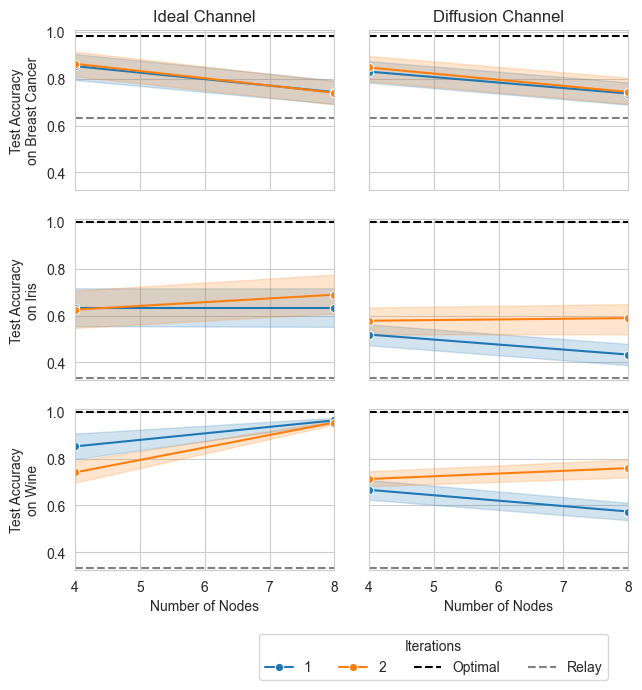

In [18]:
plot_results(df_res, df_res_nn, output_fig=os.path.join("results_cls.png"))

RL Environment

In [19]:

class MolComEnv(gym.Env):
    """
    A custom Gym environment for Molecular Communication with node failures.
    The agent learns to ensure message delivery despite node outages.
    """
    metadata = {'render_modes': ['human'], 'render_fps': 30}

    def __init__(self, dataset_name='iris', n_nodes=10, n_iters=5):
        """
        Initializes the MolComEnv environment.
        """
        super().__init__()
        # The name of the dataset to use for classification tasks, defines features and classes
        self.dataset_name = dataset_name 
        # Total number of nodes in MolCom graph
        self.n_nodes = n_nodes
        # Max number of iterations per episode
        self.n_iters = n_iters 
        # current iteration in episode
        self.current_step = 0 
        
        # Define paths for loading pre-trained encoder/decoder weights
        self.script_dir = os.getcwd()
        self.enc_dec_weights_dir = os.path.join(self.script_dir, "enc_dec_weights")

        # Load data (for message content and classification task)
        self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test = \
            get_classification_data(dataset_name)

        n_features = self.X_train.shape[1]
        n_classes = len(np.unique(self.y_train))

        # Generate graph topology or node positions for communication
        graph = generate_graph(self.n_nodes, density=0.5, random_state=42)

        # Load the pre-trained encoder
        encoder = FeedForwardNeuralNetwork(
            in_features=n_features,
            out_features=n_classes,  
            hidden_dims=[] 
        )
        encoder_weights_path = os.path.join(self.enc_dec_weights_dir, f"{dataset_name}_encoder_weights.pth")

        # Load weights that were saved
        if os.path.exists(encoder_weights_path):
            encoder.load_state_dict(torch.load(encoder_weights_path, map_location='cpu'))
            encoder.eval()  
            logger.info(f"Loaded pre-trained encoder for {dataset_name}.")
        else:
            logger.warning(f"Pre-trained encoder not found at {encoder_weights_path}. "
                           "MolComNetwork will attempt to run without it.")
            encoder = None  
            
        # Initialize Molecular Communication Network model for message passing, phi networks, and diffusion
        self.molcom_network = MolComNetwork(
            graph=graph,
            n_features=n_features,
            n_classes=n_classes,
            encoder=encoder,  
            n_iters=self.n_iters,
            hidden_dims=[4],
            use_diffusion_noise=True,
            memory=True,
            freeze_encoders=True  
        )

        # Define action and observation spaces
        # Multibinary(n_nodes) refers to the agent outputing a binary action for each node (i.e. relay strength = 1 or 0)
        self.action_space = spaces.MultiBinary(self.n_nodes)

        self.observation_space = spaces.Dict({
            # Space for continuous values referring to message concentration at each node
            "messages": spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_nodes, n_classes), dtype=np.float32),
            # A binary vector showing which nodes are operational
            "active_nodes_mask": spaces.MultiBinary(self.n_nodes)
        })
        # Tracking which nodes are currently operational
        self.active_nodes_mask = np.ones(self.n_nodes, dtype=np.int8)
        # Message concentration across all nodes at the beginning of an iteration
        self.current_message_state = torch.zeros(1, self.n_nodes, n_classes, dtype=torch.float32)

    def _get_obs(self):
        """Helper to get current observation."""
        return {
            "messages": self.current_message_state.squeeze(0).detach().numpy(),
            "active_nodes_mask": self.active_nodes_mask
        }

    def _get_info(self):
        """Helper to get current info."""
        return {"current_step": self.current_step}

    def reset(self, seed=None, options=None):
        """
        Reset the environment to an initial state.
        A new message is generated, and a random node might fail.
        """
        # Call to parent class' reset method to handle seeding for RNG
        super().reset(seed=seed)

        # All nodes active at start (all 1)
        self.active_nodes_mask = np.ones(self.n_nodes, dtype=np.int8)

        # Random node failure at 20% probability at beginning of episode
        if self.np_random.random() < 0.2:
            # Selecting random node to fail
            failed_node_idx = self.np_random.integers(0, self.n_nodes)
            # Mark current node as inactive
            self.active_nodes_mask[failed_node_idx] = 0
            #logger.info(f"Node {failed_node_idx} has failed at reset.")

        # Random data sample is selected from training set
        sample_idx = self.np_random.integers(0, len(self.X_train))
        self.current_input = torch.tensor(self.X_train[sample_idx:sample_idx + 1], dtype=torch.float32)
        self.current_target = torch.tensor(self.y_train[sample_idx:sample_idx + 1], dtype=torch.long)

        # Initialize message_state at Sender node
        self.current_message_state = torch.zeros(1, self.n_nodes, self.molcom_network.n_classes, dtype=torch.float32)

        # Encoder transforms input data into the chemical message
        if self.molcom_network.encoder is not None:
            self.current_message_state[:, self.molcom_network.sender, :] = self.molcom_network.encoder(
                self.current_input)

        # Applying ReLU as chemical concentrations are typically non-negative
        self.current_message_state = torch.relu(self.current_message_state)

        # Step counter of episode resets to 0
        self.current_step = 0

        # Return the observation (messages, active nodes, current step)
        observation = self._get_obs()
        info = self._get_info()
        return observation, info

    def step(self, action):
        """
        Execute one step in the environment.
        """
        # Increment step counter for episode
        self.current_step += 1
        # Initialize reward
        reward = 0.0
        # Boolean for episode termination (failure) or truncation(max steps or iteration per episode)
        terminated = False
        truncated = False
        
        # Introduce node failure mid episode (10% chance)
        if self.current_step > self.n_iters // 2 and self.np_random.random() < 0.1:
            # Get current active nodes
            active_indices = np.where(self.active_nodes_mask == 1)[0]
            # Active indices need to be greater than 1 to ensure more than just sender/receiver are active. 
            if len(active_indices) > 1:
                # Select random node to fail
                failed_node_idx = self.np_random.integers(0, len(active_indices))
                failed_node_idx_in_graph = active_indices[failed_node_idx]
                self.active_nodes_mask[failed_node_idx_in_graph] = 0
                #logger.info(f"Node {failed_node_idx_in_graph} has failed at step {self.current_step}.")

        # Convert agent action to represent relay strength for each node (can be 1 or 0)
        relay_strength = torch.tensor(action, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

        # Copy state of current message and move it to device used by MolComNetwork distances
        msg_for_step = self.current_message_state.clone().to(self.molcom_network.distances.device)

        # Apply active node mask, if a node is inactive it there is no message contribution
        msg_for_step = msg_for_step * torch.tensor(self.active_nodes_mask, device=msg_for_step.device,
                                                   dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

        # Apply relay strength to message
        msg_for_step = msg_for_step * relay_strength


        # Pass message through 1 iteration of MolComNetwork's message_passing function
        new_msg = message_passing(
            msg_for_step,
            self.molcom_network.distances,
            self.molcom_network.phi,
            residual_coefficient=self.molcom_network.residual_coefficient,
            output_coefficient=self.molcom_network.output_coefficient,
            memory=self.molcom_network.memory,
            use_diffusion_noise=self.molcom_network.use_diffusion_noise,
        )
        new_msg = torch.relu(new_msg)

        # Update the environment's message state
        self.current_message_state = new_msg.clone()

        # Calculate reward
        receiver_output = self.current_message_state[:, self.molcom_network.receiver, :]
        logits = receiver_output

        if self.molcom_network.n_classes > 1:
            # Get most probable class
            predicted_class = logits.argmax(dim=1) 
            # Check if class matches labelled target
            is_correct = (predicted_class == self.current_target.to(logits.device)).float().item()
            
            # Reward for correct classification
            reward = is_correct * 10.0

            # Penalty for inactive nodes
            reward -= (1 - self.active_nodes_mask).sum() * 0.1

            # if receiver node fails episode ends immediately and they is a reward penalty
            if self.active_nodes_mask[self.molcom_network.receiver] == 0:
                reward -= 5.0
                terminated = True
        else:
            # Reward is negative otherwise using MSE error
            reward = -torch.nn.functional.mse_loss(logits, self.current_target.float().to(logits.device)).item()
        # Check for early termination
        if self.current_step >= self.n_iters:
            terminated = True

            final_logits = receiver_output
            if self.molcom_network.n_classes > 1:
                final_predicted_class = final_logits.argmax(dim=1)
                final_is_correct = (final_predicted_class == self.current_target.to(logits.device)).float().item()
                # Significant reward for correct classification at the end of episode, valuing correct message for robust end-to-end communication.
                reward += final_is_correct * 50.0
        
        # Return the observation (messages, active nodes, current step)
        observation = self._get_obs()
        info = self._get_info()

        return observation, reward, terminated, truncated, info





RL agent

In [20]:
def train_rl_agent():
    
    # Using make_vec_env can run multiple environments in parallel for faster training (4 by default)
    env = make_vec_env(MolComEnv, n_envs=4, seed=0, env_kwargs={'dataset_name': 'iris', 'n_nodes': 6, 'n_iters': 8})
    
    
    # Defining a model and using "MultiInputPolicy" for dictionary-based observation space
    model = PPO("MultiInputPolicy", env, verbose=1, learning_rate=1e-4, gamma=0.99, tensorboard_log="./ppo_molcom_log/")

    # Training the agent
    logger.info("Starting RL agent training...")
    model.learn(total_timesteps=10000)  # PLEASE CHANGE THIS TO INCREASE TRAINING ITERATIONS, default value for demonstration only
    logger.info("RL agent training finished.")

    # Saving the trained agent 
    model.save("molcom_rl_agent")
    logger.info("RL agent saved as molcom_rl_agent.zip")

    # Evaluating the trained agent 
    logger.info("Evaluating the trained RL agent...")
    eval_env = MolComEnv(dataset_name='iris', n_nodes=6, n_iters=8)  
    obs, _ = eval_env.reset()
    total_reward = 0
    
    # Number of episodes to evaluate
    episodes = 5  
    for episode in range(episodes):
        done = False
        episode_reward = 0
        while not done:
            # Predict action based on current observation, choose most probable action
            action, _states = model.predict(obs, deterministic=True)
            # Take 1 step in environment with a choosen action
            obs, reward, terminated, truncated, info = eval_env.step(action)
            # Episode ends if a receiver node failed or max steps are reached
            done = terminated or truncated
            # Accumulate reward for the episode
            episode_reward += reward
        # Add episode reward to total
        total_reward += episode_reward
        logger.info(f"Evaluation Episode {episode + 1}: Total Reward = {episode_reward:.2f}")
        # Reset for next episode
        obs, _ = eval_env.reset()  
    logger.info(f"Average reward over {episodes} evaluation episodes: {total_reward / episodes:.2f}")
    eval_env.close()  # Close evaluation environment

In [22]:
if __name__ == "__main__":
    logger.info("Starting data preprocessing and encoder-decoder training.")
    # Get current directory
    script_dir = os.getcwd()
    # Define directory for weights
    enc_dec_weights_dir = os.path.join(script_dir, "enc_dec_weights")
    # Create a directory if it doesn't exist
    os.makedirs(enc_dec_weights_dir, exist_ok=True)

    # Path for results, CSV
    res_csv_path = os.path.join(enc_dec_weights_dir, "enc_dec_results.csv")
    if os.path.exists(res_csv_path):
        df = pd.read_csv(res_csv_path)
        logger.info(f"Loaded existing results from {res_csv_path}")
    else:
        # Create and save dataframe
        df = pd.DataFrame(columns=["dataset", "n_features", "n_classes", "acc"])
        df.to_csv(res_csv_path, index=False)
        logger.info(f"Created new results file at {res_csv_path}")

    # Loop through each dataset to train or load encoder-decoder models
    for dataset_name in DATASETS:
        if dataset_name in ["identity", "shift", "negate"]:
            logger.info(f"Skipping dataset: {dataset_name}")
            continue

        enc_path = os.path.join(enc_dec_weights_dir, f"{dataset_name}_encoder_weights.pth")
        dec_path = os.path.join(enc_dec_weights_dir, f"{dataset_name}_decoder_weights.pth")

        # Check if encoder/decoder weights exist already
        if not os.path.exists(enc_path) or not os.path.exists(dec_path):
            logger.info(f"Training encoder-decoder for dataset: {dataset_name}")
            X_train, X_val, X_test, y_train, y_val, y_test = get_classification_data(dataset_name)
            n_features = X_train.shape[1]
            n_classes = len(np.unique(y_train))
            _, _, acc = train_encoder_decoder(
                X_train, y_train, X_val, y_val, X_test, y_test,
                n_features, n_classes, hidden_dims=[], use_batchnorm=False,
                lr=1e-3, n_epochs=10000, patience=100, batch_size=1024,
                device = "cuda" , weights_dir=enc_dec_weights_dir, verbose=True,
            )
            logger.info(f"Finished training encoder-decoder on {dataset_name}. Test Accuracy: {acc:.4f}")
            new_row = pd.DataFrame(
                {"dataset": [dataset_name], "n_features": [n_features], "n_classes": [n_classes], "acc": [acc]})
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                df = pd.concat([df, new_row], ignore_index=True)
            df.to_csv(res_csv_path, index=False)
            logger.info(f"Updated results file: {res_csv_path}")
        else:
            logger.info(f"Encoder-decoder weights already exist for {dataset_name}. Skipping training.")

    logger.info("All specified datasets processed for encoder-decoder training.")
    print("\n--- Encoder-Decoder Training Results ---")
    print(df)
    print("--------------------------------------")

    logger.info("Attempting to run RL agent training...")
    try:
        train_rl_agent()
    except Exception as e:
        logger.error(f"Error during RL agent training: {e}")

2025-06-27 11:22:48,805 - INFO - Starting data preprocessing and encoder-decoder training.
2025-06-27 11:22:48,809 - INFO - Loaded existing results from C:\Users\New\Desktop\Commence\commence-tmbc\enc_dec_weights\enc_dec_results.csv
2025-06-27 11:22:48,810 - INFO - Encoder-decoder weights already exist for iris. Skipping training.
2025-06-27 11:22:48,811 - INFO - Encoder-decoder weights already exist for wine. Skipping training.
2025-06-27 11:22:48,812 - INFO - Encoder-decoder weights already exist for breast_cancer. Skipping training.
2025-06-27 11:22:48,813 - INFO - All specified datasets processed for encoder-decoder training.
2025-06-27 11:22:48,815 - INFO - Attempting to run RL agent training...
2025-06-27 11:22:48,821 - INFO - Loaded pre-trained encoder for iris.
2025-06-27 11:22:48,829 - INFO - Loaded pre-trained encoder for iris.
2025-06-27 11:22:48,837 - INFO - Loaded pre-trained encoder for iris.
2025-06-27 11:22:48,845 - INFO - Loaded pre-trained encoder for iris.
2025-06-27


--- Encoder-Decoder Training Results ---
         dataset  n_features  n_classes       acc
0           iris           4          3  1.000000
1           wine          13          3  1.000000
2  breast_cancer          30          2  0.982456
--------------------------------------
Using cpu device
Logging to ./ppo_molcom_log/PPO_12
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.42     |
|    ep_rew_mean     | 39.7     |
| time/              |          |
|    fps             | 444      |
|    iterations      | 1        |
|    time_elapsed    | 18       |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 7.65        |
|    ep_rew_mean          | 32.4        |
| time/                   |             |
|    fps                  | 405         |
|    iterations           | 2           |
|    time_elapsed         | 40   

2025-06-27 11:23:34,492 - INFO - RL agent training finished.
2025-06-27 11:23:34,502 - INFO - RL agent saved as molcom_rl_agent.zip
2025-06-27 11:23:34,503 - INFO - Evaluating the trained RL agent...
2025-06-27 11:23:34,507 - INFO - Loaded pre-trained encoder for iris.
2025-06-27 11:23:34,524 - INFO - Evaluation Episode 1: Total Reward = 129.20
2025-06-27 11:23:34,541 - INFO - Evaluation Episode 2: Total Reward = 0.00
2025-06-27 11:23:34,557 - INFO - Evaluation Episode 3: Total Reward = 130.00
2025-06-27 11:23:34,573 - INFO - Evaluation Episode 4: Total Reward = -0.30
2025-06-27 11:23:34,592 - INFO - Evaluation Episode 5: Total Reward = -1.10
2025-06-27 11:23:34,594 - INFO - Average reward over 5 evaluation episodes: 51.56
